# Baseline Model

We choose to train a Variational Autoencoder (VAE) as our baseline model, as it is a fairly simple model that can generate images. In this python notebook we will evaluate the performance of a simple VAE model, trained on the Flowers and on the CelebA dataset.


### Imports:


In [1]:
from data_preparation import dataloader_service
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
import random

### Set device:


In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_built() else "cpu"
)
print(f"Device: {device}")

Device: mps


### Set parameters


In [3]:
IMAGE_SIZE = 128
LATENT_DIM = 256
image_dim = IMAGE_SIZE * IMAGE_SIZE * 3
batch_size = 32
num_epoch = 10

### Load datasets


In [4]:
flowers_train_loader, flowers_val_loader, flowers_test_loader = (
    dataloader_service.get_dataloader(
        dataset_name="Flowers", batch_size=batch_size, shuffle=True, device=device
    )
)

celeb_train_loader, celeb_val_loader, celeb_test_loader = (
    dataloader_service.get_dataloader(
        dataset_name="CelebA", batch_size=batch_size, shuffle=True, device=device
    )
)

### Examine some images from datasets


In [5]:
def show_random_image(train_loader):
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    idx = np.random.choice(len(images))
    plt.imshow(images[idx].permute(1, 2, 0).to("cpu"), cmap="gray")
    plt.title("Típus: " + str(labels[idx].item()))

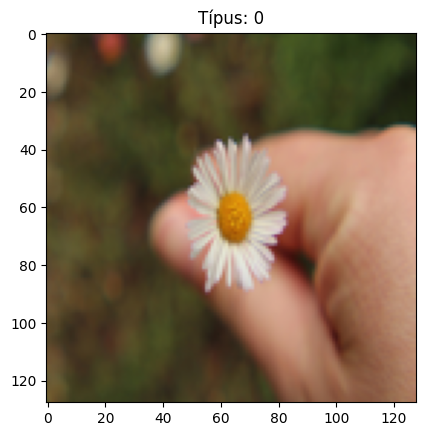

In [6]:
show_random_image(flowers_train_loader)

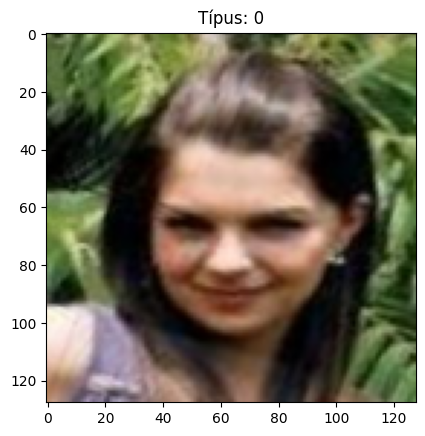

In [7]:
show_random_image(celeb_train_loader)

### Define Variational Autoencoder Model


In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        hidden_dims = [32, 64, 128, 256, 512]
        self.final_dim = hidden_dims[-1]
        in_channels = 3
        modules = []

        # Encoder
        for dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = dim

        self.encoder = nn.Sequential(*modules)
        out = self.encoder(torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE))
        self.size = out.shape[2]
        self.fc_mu = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)
        self.fc_logvar = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)

        # Decoder
        modules = []
        self.decoder_input = nn.Linear(
            LATENT_DIM, hidden_dims[-1] * self.size * self.size
        )
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_logvar(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.final_dim, self.size, self.size)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

### Define training method


In [9]:
def train(train_loader, num_epoch=num_epoch):
    torch.cuda.empty_cache()
    torch.mps.empty_cache()
    model = VAE().to(device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epoch):
        for i, (x_batch, _) in enumerate(train_loader):
            x_batch_gpu = x_batch.to(device)
            x_rec, mu, lv = model(x_batch_gpu)
            kl = torch.sum(0.5 * (mu**2 + (torch.exp(lv)) - 1 - lv))
            kl_normalized = kl / x_batch_gpu.size(0)
            loss = torch.sum((x_batch_gpu - x_rec) ** 2) + kl_normalized
            percentage = (
                (epoch * len(train_loader) + i + 1)
                / (num_epoch * len(train_loader))
                * 100
            )
            print(
                f"Epoch: {epoch+1}/{num_epoch}, Batch: {i+1}/{len(train_loader)} ({percentage:.2f}%) - Loss: {loss.item()}",
                end="\r",
            )
            opt.zero_grad()
            loss.backward()
            opt.step()
    return model

### Train the models on both datasets


In [10]:
model_flowers = train(flowers_train_loader)

In [11]:
model_celeb = train(celeb_train_loader, num_epoch=2)

### Generate images


In [12]:
def generate_images(model):
    with torch.no_grad():
        out = model.decode(torch.randn(5, LATENT_DIM).to(device))

    f, ax = plt.subplots(1, 5, figsize=(10, 3))
    for i in range(5):
        ax[i].imshow(out[i].cpu().permute(1, 2, 0), cmap="gray")

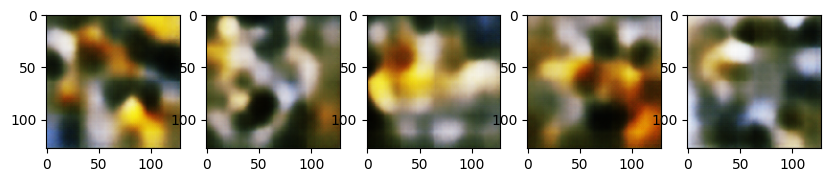

In [13]:
generate_images(model_flowers)

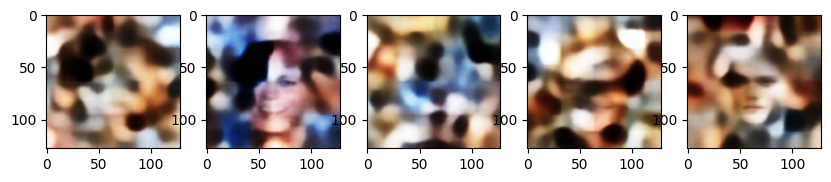

In [14]:
generate_images(model_celeb)

### Reconstruct images


In [15]:
def compare_images(model, test_loader):

    # Get a batch of images from the test DataLoader
    images, _ = next(iter(test_loader))  # Get the first batch from the test loader

    # Select a random image from the batch
    random_index = random.randint(0, images.size(0) - 1)
    image = (
        images[random_index].unsqueeze(0).to(device)
    )  # Add batch dimension and move to device

    # Ensure the model is in evaluation mode
    model.eval()

    # Pass the image through the VAE to get the reconstructed image
    with torch.no_grad():
        mu, log_var = model.encode(image)
        z = model.reparameterize(mu, log_var)
        reconstructed_image = model.decode(z)

    # Move the images to CPU and remove batch dimension for visualization
    original_image = image.squeeze(0).cpu().permute(1, 2, 0)
    reconstructed_image = reconstructed_image.squeeze(0).cpu().permute(1, 2, 0)

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_image)
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    plt.show()

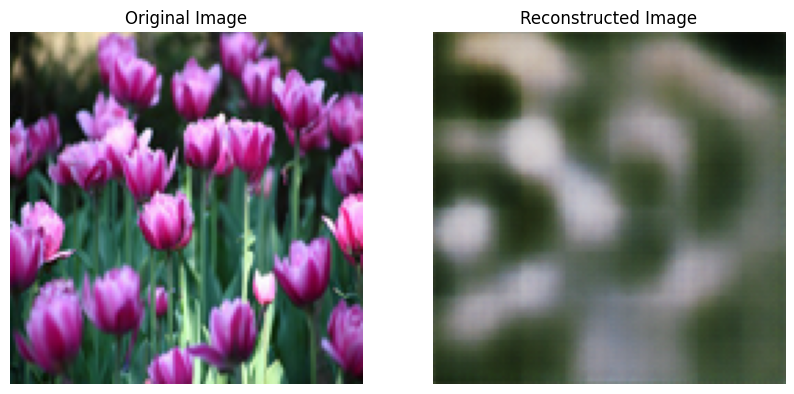

In [16]:
compare_images(model_flowers, flowers_test_loader)

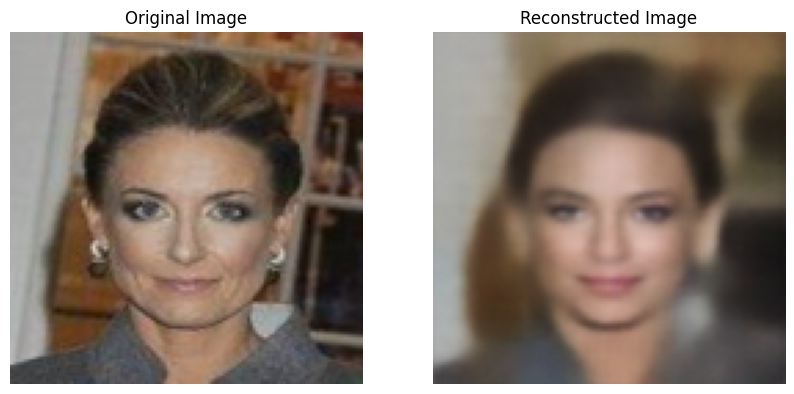

In [17]:
compare_images(model_celeb, celeb_test_loader)

### Evaluate FID score


In [18]:
def calculate_fid_score(model, test_loader, device="cpu"):
    # Initialize FID metric and move it to CPU
    fid_metric = FrechetInceptionDistance(feature=2048).to(
        device=device, dtype=torch.float32
    )

    model.to(device).eval()

    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):

            print(f"Batch: {idx+1}/{len(test_loader)}", end="\r")
            if idx > 2:
                continue
            real_images = (images * 255).clamp(0, 255).to(torch.uint8).to(device)

            reconstructed_images = []
            for img in images:
                img = img.unsqueeze(0).to(device)
                mu, log_var = model.encode(img)
                z = model.reparameterize(mu, log_var)
                reconstructed_img = model.decode(z)
                reconstructed_images.append(reconstructed_img.squeeze(0))

            reconstructed_images = (
                torch.stack(reconstructed_images).mul(255).clamp(0, 255).to(torch.uint8)
            )

            fid_metric.update(real_images, real=True)
            fid_metric.update(reconstructed_images, real=False)

    fid_score = fid_metric.compute()
    return fid_score.item()

In [19]:
fid_score_flowers = calculate_fid_score(model_flowers, flowers_test_loader)
fid_score_celeb = calculate_fid_score(model_celeb, celeb_test_loader)

print(f"FID Score for Flowers: {fid_score_flowers}")
print(f"FID Score for CelebA: {fid_score_celeb}")

FID Score for Flowers: 306.0416564941406
FID Score for CelebA: 156.39808654785156


### Short evaluation

We can see, that the baseline model works as intended, but does not perform so well. It is much better however on the CelebA dataset which is caused by the much larger size of that when compared to the flowers dataset. In the CelebA dataset the reconstruction is quite good, considering the faces, but there is room to improve in the field of image generation.